In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import scipy.stats as sts
import quandl
import os
from config import api_key
import numpy as np
from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr

In [2]:
# Importing Quandl data using the API

In [3]:
try:
    B_Spread = quandl.get("ML/BEY", authtoken=api_key)
    Treasury_curve = quandl.get("USTREASURY/YIELD", authtoken=api_key)
    SP_500 = quandl.get("CHRIS/CME_ES2")
except Exception as e:
    print(e)

## S&P500 DataFrame

In [4]:
SP_500.reset_index(inplace=True)
SP_500

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
0,1997-09-09,943.50,951.00,941.50,944.00,NaN,944.00,896.0,273.0
1,1997-09-10,942.75,943.25,917.00,925.00,NaN,925.00,12261.0,382.0
2,1997-09-11,924.00,929.75,910.25,918.25,NaN,918.25,9759.0,2909.0
3,1997-09-12,918.00,936.50,913.50,933.75,NaN,933.75,18496.0,4059.0
4,1997-09-15,933.50,939.75,929.00,931.50,NaN,931.50,11749.0,3818.0
...,...,...,...,...,...,...,...,...,...
5793,2020-06-15,2983.25,3068.25,2923.75,3065.50,38.25,3062.00,2958270.0,906306.0
5794,2020-06-16,3065.25,3156.25,3060.25,3116.00,56.25,3118.25,2979960.0,1678383.0
5795,2020-06-17,3111.75,3147.00,3094.50,3106.50,11.25,3107.00,1829020.0,2179528.0
5796,2020-06-18,3104.00,3120.00,3064.50,3099.25,9.00,3098.00,1617572.0,2436145.0


In [5]:
# Sub data frame with Settle Price only
SP500_Price_df = pd.DataFrame({'Date': SP_500['Date'],
                               'Closing Price': SP_500['Settle']
                              })
SP500_Price_df

,Date,Closing Price
0,1997-09-09,944.00
1,1997-09-10,925.00
2,1997-09-11,918.25
3,1997-09-12,933.75
4,1997-09-15,931.50
...,...,...
5793,2020-06-15,3062.00
5794,2020-06-16,3118.25
5795,2020-06-17,3107.00
5796,2020-06-18,3098.00


## Resetting B Spread dataframe 

In [6]:
B_Spread.reset_index(inplace=True)
B_Spread.columns = ['Date','B Rating']
B_Spread

,Date,B Rating
0,1996-12-31,10.01
1,1997-01-02,10.00
2,1997-01-03,10.01
3,1997-01-06,10.05
4,1997-01-07,10.07
...,...,...
6119,2020-06-12,6.73
6120,2020-06-15,6.69
6121,2020-06-16,6.23
6122,2020-06-17,6.29


In [7]:
# Convert to datetime object
B_Spread['Date'] = pd.to_datetime(B_Spread['Date'])

In [8]:
# Filter dates
New_B_Spread = B_Spread.loc[(B_Spread['Date']>='1997-09-09')]
New_B_Spread

,Date,B Rating
176,1997-09-09,9.59
177,1997-09-10,9.58
178,1997-09-11,9.60
179,1997-09-12,9.58
180,1997-09-15,9.55
...,...,...
6119,2020-06-12,6.73
6120,2020-06-15,6.69
6121,2020-06-16,6.23
6122,2020-06-17,6.29


## Treasury Curve DataFrame

In [9]:
# Resetting the index
Treasury_curve = Treasury_curve.reset_index()

In [10]:
# Converting to datetime objects 
Treasury_curve['Date'] = pd.to_datetime(Treasury_curve['Date'])
Treasury_curve

,Date,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
0,1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1,1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
2,1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
3,1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
4,1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7618,2020-06-15,0.15,0.16,0.18,0.19,0.17,0.19,0.22,0.33,0.54,0.71,1.24,1.45
7619,2020-06-16,0.14,0.15,0.17,0.19,0.18,0.21,0.23,0.34,0.56,0.75,1.31,1.54
7620,2020-06-17,0.13,0.15,0.17,0.18,0.19,0.19,0.23,0.34,0.55,0.74,1.30,1.52
7621,2020-06-18,0.13,0.14,0.16,0.17,0.19,0.19,0.22,0.34,0.54,0.71,1.24,1.47


In [11]:
# Filtering the dates to match S&P500
New_Treasury_curve = Treasury_curve.loc[(Treasury_curve['Date']>='1997-09-09')]
New_Treasury_curve

,Date,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
1924,1997-09-09,NaN,NaN,5.16,5.35,5.60,5.98,6.09,6.24,6.33,6.34,6.70,6.63
1925,1997-09-10,NaN,NaN,5.11,5.35,5.61,6.00,6.10,6.26,6.36,6.37,6.71,6.66
1926,1997-09-11,NaN,NaN,5.13,5.36,5.59,6.00,6.11,6.27,6.38,6.39,6.75,6.68
1927,1997-09-12,NaN,NaN,5.10,5.32,5.54,5.93,6.03,6.17,6.28,6.29,6.66,6.59
1928,1997-09-15,NaN,NaN,5.08,5.31,5.54,5.93,6.02,6.17,6.28,6.28,6.65,6.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7618,2020-06-15,0.15,0.16,0.18,0.19,0.17,0.19,0.22,0.33,0.54,0.71,1.24,1.45
7619,2020-06-16,0.14,0.15,0.17,0.19,0.18,0.21,0.23,0.34,0.56,0.75,1.31,1.54
7620,2020-06-17,0.13,0.15,0.17,0.18,0.19,0.19,0.23,0.34,0.55,0.74,1.30,1.52
7621,2020-06-18,0.13,0.14,0.16,0.17,0.19,0.19,0.22,0.34,0.54,0.71,1.24,1.47


In [12]:
# Final Treasury DataFrame
Treasury_5_Year = pd.DataFrame({'Date': New_Treasury_curve['Date'],
                                '5 Year Rate': New_Treasury_curve['5 YR']
                               })
Treasury_5_Year

,Date,5 Year Rate
1924,1997-09-09,6.24
1925,1997-09-10,6.26
1926,1997-09-11,6.27
1927,1997-09-12,6.17
1928,1997-09-15,6.17
...,...,...
7618,2020-06-15,0.33
7619,2020-06-16,0.34
7620,2020-06-17,0.34
7621,2020-06-18,0.34


## Merging DataFrames

In [13]:
SP500_BondSpread_df = pd.merge(SP500_Price_df,New_B_Spread, on='Date')

In [14]:
SP500_BondSpread_df

,Date,Closing Price,B Rating
0,1997-09-09,944.00,9.59
1,1997-09-10,925.00,9.58
2,1997-09-11,918.25,9.60
3,1997-09-12,933.75,9.58
4,1997-09-15,931.50,9.55
...,...,...,...
5782,2020-06-12,3023.75,6.73
5783,2020-06-15,3062.00,6.69
5784,2020-06-16,3118.25,6.23
5785,2020-06-17,3107.00,6.29


In [15]:
# Final DataFrame
Final_Market_Data_df = pd.merge(SP500_BondSpread_df,Treasury_5_Year,on='Date')

In [16]:
Final_Market_Data_df

,Date,Closing Price,B Rating,5 Year Rate
0,1997-09-09,944.00,9.59,6.24
1,1997-09-10,925.00,9.58,6.26
2,1997-09-11,918.25,9.60,6.27
3,1997-09-12,933.75,9.58,6.17
4,1997-09-15,931.50,9.55,6.17
...,...,...,...,...
5683,2020-06-12,3023.75,6.73,0.33
5684,2020-06-15,3062.00,6.69,0.33
5685,2020-06-16,3118.25,6.23,0.34
5686,2020-06-17,3107.00,6.29,0.34


## DataFrame Calculations
- Calculate the Credit Spread (B rated yields - 5Yr Treasury Rate)
- Calculate the SP500, B rating yield and 5Yr Treasruy returns

In [17]:
# Yield Spread Calculation
Final_Market_Data_df['Yield Spread'] = Final_Market_Data_df['B Rating'] - Final_Market_Data_df['5 Year Rate']

# Calculating S&P500 Returns
Final_Market_Data_df['S&P 500 Returns'] = Final_Market_Data_df['Closing Price'].pct_change()

# Calculating Yield Spread Returns
Final_Market_Data_df['Yield Spread Returns'] = Final_Market_Data_df['Yield Spread'].pct_change()

In [18]:
Final_Market_Data_df

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns
0,1997-09-09,944.00,9.59,6.24,3.35,NaN,NaN
1,1997-09-10,925.00,9.58,6.26,3.32,-0.020127,-0.008955
2,1997-09-11,918.25,9.60,6.27,3.33,-0.007297,0.003012
3,1997-09-12,933.75,9.58,6.17,3.41,0.016880,0.024024
4,1997-09-15,931.50,9.55,6.17,3.38,-0.002410,-0.008798
...,...,...,...,...,...,...,...
5683,2020-06-12,3023.75,6.73,0.33,6.40,0.008085,-0.016897
5684,2020-06-15,3062.00,6.69,0.33,6.36,0.012650,-0.006250
5685,2020-06-16,3118.25,6.23,0.34,5.89,0.018370,-0.073899
5686,2020-06-17,3107.00,6.29,0.34,5.95,-0.003608,0.010187


Text(0.5, 1.0, 'Junk Bond vs 5 Year Treasury Spread')

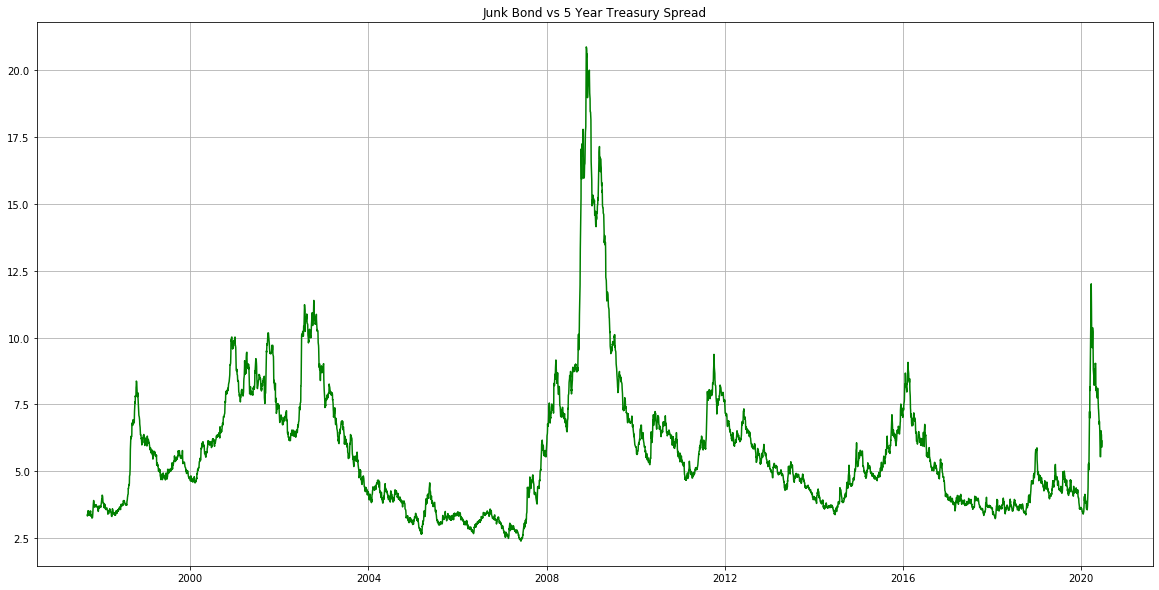

In [19]:
# Plotting the Spread
fig = plt.figure(figsize = (20,10))

plt.plot(Final_Market_Data_df['Date'],Final_Market_Data_df['Yield Spread'],'-g', label="Yield Spread")
plt.grid(True)
plt.title('Junk Bond vs 5 Year Treasury Spread')

## Correlation/Z-Score Parameters

In [20]:
# Correlation
Rolling_window = 55

Final_Market_Data_df['Correl'+ str(Rolling_window) + 'day'] = Final_Market_Data_df['S&P 500 Returns'].rolling(window=Rolling_window).corr(Final_Market_Data_df['Yield Spread Returns'])
Final_Market_Data_df

# Standard derviation
Final_Market_Data_df[str(Rolling_window)+ 'Day std'] = Final_Market_Data_df['Correl'+ str(Rolling_window) + 'day'].rolling(Rolling_window).std()
Final_Market_Data_df

# Rolling Mean
Final_Market_Data_df[str(Rolling_window)+ 'Day Mean'] = Final_Market_Data_df['Correl'+ str(Rolling_window) + 'day'].rolling(Rolling_window).mean()

# Rolling Z-Score
Final_Market_Data_df[str(Rolling_window)+ 'Z-Score'] = ((Final_Market_Data_df['Correl'+ str(Rolling_window) + 'day'] - Final_Market_Data_df[str(Rolling_window)+ 'Day Mean'])/Final_Market_Data_df[str(Rolling_window)+ 'Day std'])


In [21]:
Final_Market_Data_df.columns = ['Date','Closing_Price','B_Rating', '5_YR','Yield_Spread','SP500_Returns','Yield_Spread_Returns','Correl55day','55Day_Std','55Day_Mean','Z_Score']

In [22]:
Final_Market_Data_df

,Date,Closing_Price,B_Rating,5_YR,Yield_Spread,SP500_Returns,Yield_Spread_Returns,Correl55day,55Day_Std,55Day_Mean,Z_Score
0,1997-09-09,944.00,9.59,6.24,3.35,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-09-10,925.00,9.58,6.26,3.32,-0.020127,-0.008955,NaN,NaN,NaN,NaN
2,1997-09-11,918.25,9.60,6.27,3.33,-0.007297,0.003012,NaN,NaN,NaN,NaN
3,1997-09-12,933.75,9.58,6.17,3.41,0.016880,0.024024,NaN,NaN,NaN,NaN
4,1997-09-15,931.50,9.55,6.17,3.38,-0.002410,-0.008798,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5683,2020-06-12,3023.75,6.73,0.33,6.40,0.008085,-0.016897,-0.525355,0.078715,-0.665658,1.782420
5684,2020-06-15,3062.00,6.69,0.33,6.36,0.012650,-0.006250,-0.473609,0.081946,-0.660598,2.281844
5685,2020-06-16,3118.25,6.23,0.34,5.89,0.018370,-0.073899,-0.505603,0.083969,-0.656497,1.797022
5686,2020-06-17,3107.00,6.29,0.34,5.95,-0.003608,0.010187,-0.505388,0.085687,-0.652325,1.714810


## Saving Market Data DF to csv

In [23]:
Final_Market_Data_df.to_csv('Ben_Final2_Data_df.csv', encoding='utf-8')

## Z-Score/Correl Plots

Text(0.5, 1.0, 'Correl Z-Score vs S&P500 Index')

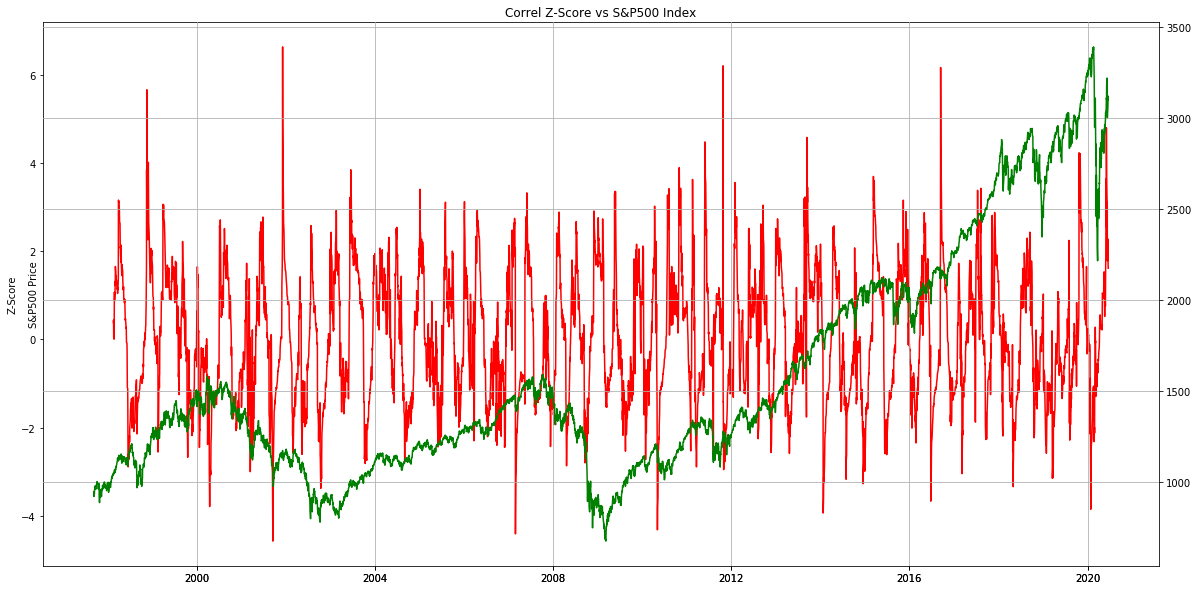

In [24]:
# fig = plt.figure(figsize = (20,10))

# plt.plot(Final_Market_Data_df['Date'],Final_Market_Data_df[str(Rolling_window)+ 'Z-Score'],'-g', label="Z-Score")
# plt.grid(True)
# plt.title('Correlation Z-Score ')

# Generating the chart
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(Final_Market_Data_df['Date'],Final_Market_Data_df['Z_Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(Final_Market_Data_df['Date'],Final_Market_Data_df['Closing_Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')


In [25]:
# Plotting the S&P500

# fig = plt.figure(figsize = (20,10))

# plt.plot(Final_Market_Data_df['Date'],Final_Market_Data_df['Closing Price'],'-g', label="Z-Score")
# plt.grid(True)
# plt.title('S&P500')

In [26]:
My_market_data_df = Final_Market_Data_df

## Signal Function

In [27]:
def my_signal(row):
    if row[str(Rolling_window)+ 'Z-Score']>=2.5:
        return row[str(Rolling_window)+ 'Z-Score']
    elif row[str(Rolling_window)+ 'Z-Score'] <=-2.5:
        return row[str(Rolling_window)+ 'Z-Score']
    else:
        return 0
    
My_market_data_df['signal'] = My_market_data_df.apply(my_signal, axis=1)

KeyError: ('55Z-Score', 'occurred at index 0')

In [ ]:
My_market_data_df

In [ ]:
My_market_data_df.to_csv('final_market_data.csv', encoding = 'utf-8')

In [ ]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(My_market_data_df['Date'],My_market_data_df['signal'],'-r', label="Z-Score Signal")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(My_market_data_df['Date'],My_market_data_df['Closing Price'],'-g', label="SP500")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

In [ ]:
Final_Market_Data_df

## 1997-2003

In [ ]:
# Data Frame inputs
ltcm_df = My_market_data_df.loc[(My_market_data_df['Date']>='1997-09-09') & (My_market_data_df['Date']<='2003-12-31')]
ltcm_df

In [ ]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(ltcm_df['Date'],ltcm_df['signal'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(ltcm_df['Date'],ltcm_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

## Saving to csv

In [ ]:
ltcm_df.to_csv("LTCM_period.csv",encoding='utf-8' )

## 2004-2009

In [ ]:
financial_crisis_df = Final_Market_Data_df.loc[(Final_Market_Data_df['Date']>='2004-01-01') & (Final_Market_Data_df['Date']<='2009-12-31')]
financial_crisis_df

In [ ]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(financial_crisis_df['Date'],financial_crisis_df[str(Rolling_window)+ 'Z-Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(financial_crisis_df['Date'],financial_crisis_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

## 2010-2015

In [ ]:
recovery_df = Final_Market_Data_df.loc[(Final_Market_Data_df['Date']>='2010-01-01') & (Final_Market_Data_df['Date']<='2015-12-31')]
recovery_df

In [ ]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(recovery_df['Date'],recovery_df[str(Rolling_window)+ 'Z-Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(recovery_df['Date'],recovery_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

## 2016-2020

In [ ]:
latest_df = Final_Market_Data_df.loc[(Final_Market_Data_df['Date']>='2016-01-01') & (Final_Market_Data_df['Date']<='2020-06-11')]
latest_df

In [ ]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(latest_df['Date'],latest_df[str(Rolling_window)+ 'Z-Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(latest_df['Date'],latest_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

## Yield Spread Ratio Analysis

In [ ]:
Ratio_df = Final_Market_Data_df

In [ ]:
# Calculate the Junk Bond to Treasury Yield Ratio
Ratio_df['Junk/Treasury'] = Ratio_df['B Rating'] / Ratio_df['5 Year Rate']

In [ ]:
# Calculate the historical Volatilities of the ratio
vol_window = [21,55,100]
daily_vol = np.sqrt(252)

for vol in vol_window:
    Ratio_df[str(vol) + 'day vol'] = Ratio_df['Junk/Treasury'].rolling(vol).std()*daily_vol


In [ ]:
print(daily_vol)
print(np.sqrt(252))

In [ ]:
Ratio_df.head(100)

In [ ]:
# Scatter Plot
fig = plt.figure(figsize = (20,10))

plt.scatter(x = Ratio_df['Yield Spread Returns'],
            y = Ratio_df['S&P 500 Returns'])
plt.grid(True)
plt.title('Yield Spread Return vs S&P500 Returns Scatter')
plt.xlabel('S&P500 Returns')
plt.ylabel('Yield Spread Returns')

## Correlation S&P500 Returns vs Yield Spread Returns

In [ ]:
# Correlation
x = Ratio_df['Yield Spread Returns'].dropna()
y = Ratio_df['S&P 500 Returns'].dropna()

print(pearsonr(x,y))

## Linear Regression S&P500 Returns vs Yield Spread Returns

In [ ]:
# Variables for the regression
x_values = Ratio_df['Yield Spread Returns'].dropna()
y_values = Ratio_df['S&P 500 Returns'].dropna()

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,1)) + "x + " + str(round(intercept,1))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.002, 0),fontsize=15,color="red")
plt.xlabel('Yield Spread Return')
plt.ylabel("S&P 500 Returns")

print(f"rvalue    = {round(rvalue, 3)}")
print(f"r-squared = {round(rvalue**2, 3)}")

plt.show()

In [ ]:
Ratio_df['S&P 500 Returns'].hist()

In [ ]:
Ratio_df['Yield Spread Returns'].hist()

In [ ]:
x = Ratio_df['Yield Spread']
x

In [ ]:
x.diff(periods=1)

## Adding Yield Spread Absolute Change

In [ ]:
Ratio_df['Change in bps'] = Ratio_df['Yield Spread'].diff(periods=1)*100

In [ ]:
Ratio_df

In [ ]:
fig = plt.figure(figsize = (20,10))

plt.scatter(x = Ratio_df['Change in bps'],
            y = Ratio_df['S&P 500 Returns'])
plt.grid(True)
plt.title('Scatter Plot S&P500 Returns vs Yield Spread Absolute Change')
plt.xlabel('Change in bps')
plt.ylabel('S&P 500 Returns')

In [ ]:
# Correlation
x = Ratio_df['Change in bps'].dropna()
y = Ratio_df['S&P 500 Returns'].dropna()

print(pearsonr(x,y))

In [ ]:
# Plotting the Spread
fig = plt.figure(figsize = (20,10))

plt.plot(Ratio_df['Date'],Ratio_df['Change in bps'],'-g', label="Yield Spread")
plt.grid(True)
plt.title('Spread Change in bps')



## Adding SP500 Historical Vol

In [ ]:
Ratio_df

In [ ]:
# Calculate the historical Volatilities of the ratio
vol_window = [21,55,100]
daily_vol = np.sqrt(252)

for vol in vol_window:
    Ratio_df[str(vol) + 'day vol'] = Ratio_df['Junk/Treasury'].rolling(vol).std()*daily_vol